In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, classification_report
from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
fer_directory = 'data/FER2013'
ck_directory = 'data/CK+'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version: 2.10.1
Num GPUs Available:  1


In [7]:
# Initialise generator with rescale factor 1./255
train_gen = ImageDataGenerator(rescale=1./255, rotation_range=10,  zoom_range=0.1, horizontal_flip=True, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.1, horizontal_flip=True)

# Preprocess training set
train_generator = train_gen.flow_from_directory(
    fer_directory + '/train',
    target_size=(48,48),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_gen.flow_from_directory(
    fer_directory + '/train',
    target_size=(48,48),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Preprocess test set
# False shuffle so classification dont get mixed
test_generator = test_gen.flow_from_directory(
    fer_directory + '/test',
    target_size=(48,48),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


<h1>First Model Run</h1>

In [3]:
# Define model
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2nd convolution layer
model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3rd convolution layer
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten and feed into dense layer
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(7, activation='softmax'))

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [11]:
# Plots image
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
# Image('model.png',width=400, height=200)

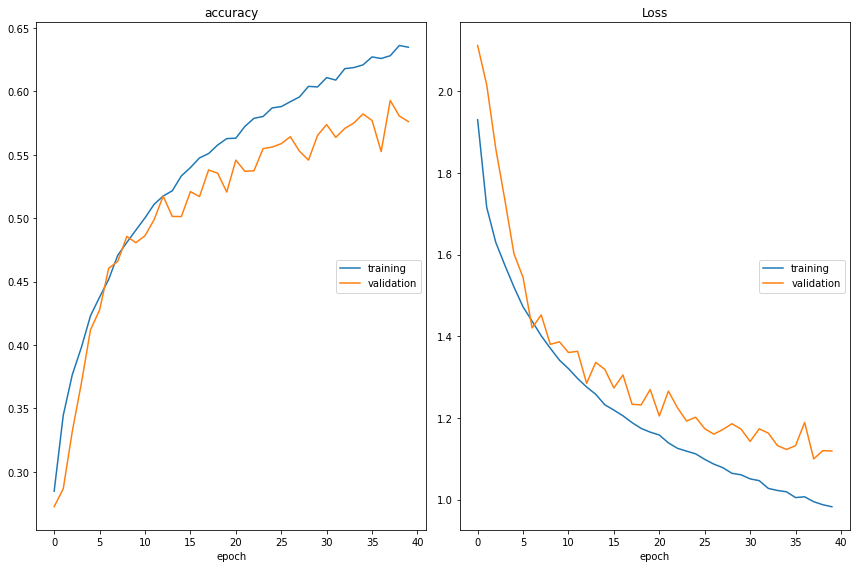

accuracy
	training         	 (min:    0.285, max:    0.636, cur:    0.635)
	validation       	 (min:    0.272, max:    0.593, cur:    0.576)
Loss
	training         	 (min:    0.982, max:    1.931, cur:    0.982)
	validation       	 (min:    1.100, max:    2.113, cur:    1.119)
179/179 [==============================] - 26s 143ms/step - loss: 0.9824 - accuracy: 0.6349 - val_loss: 1.1190 - val_accuracy: 0.5762


In [4]:
# Train model
epochs = 40
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Reduce learning rate when a metric has stopped improving
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')

# Stop training when val loss has stopped improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save model weights
checkpoint = ModelCheckpoint('model_weights_first.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)

# Train model
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, PlotLossesKeras()],
)

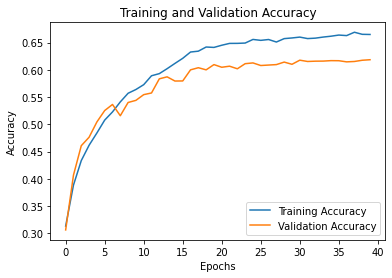

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(0)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Accuracy.png')
plt.show()

<h1>Model with hyperparameter optimisation</h1>

<h1>New Model</h1>

In [9]:
# Reference model
ref_model = Sequential()

ref_model.add(Conv2D(256, (3,3), padding='same', input_shape=(48,48,1), activation='relu'))
ref_model.add(Conv2D(516, (3,3), padding='same', activation='relu'))
ref_model.add(BatchNormalization())
ref_model.add(MaxPooling2D(pool_size=(2,2)))
ref_model.add(Dropout(0.4))

ref_model.add(Conv2D(384, (3,3), padding='same', activation='relu'))
ref_model.add(BatchNormalization())
ref_model.add(MaxPooling2D(pool_size=(2,2)))
ref_model.add(Dropout(0.4))

ref_model.add(Conv2D(192, (3,3), padding='same', activation='relu'))
ref_model.add(BatchNormalization())
ref_model.add(MaxPooling2D(pool_size=(2,2)))
ref_model.add(Dropout(0.4))

ref_model.add(Conv2D(384, (3,3), padding='same', activation='relu'))
ref_model.add(BatchNormalization())
ref_model.add(MaxPooling2D(pool_size=(2,2)))
ref_model.add(Dropout(0.4))

ref_model.add(Flatten())
ref_model.add(Dense(256, activation='relu'))
ref_model.add(BatchNormalization())

ref_model.add(Dropout(0.3))
ref_model.add(Dense(7, activation='softmax'))

ref_model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
ref_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 256)       2560      
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 516)       1189380   
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 516)      2064      
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 516)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 516)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 384)      

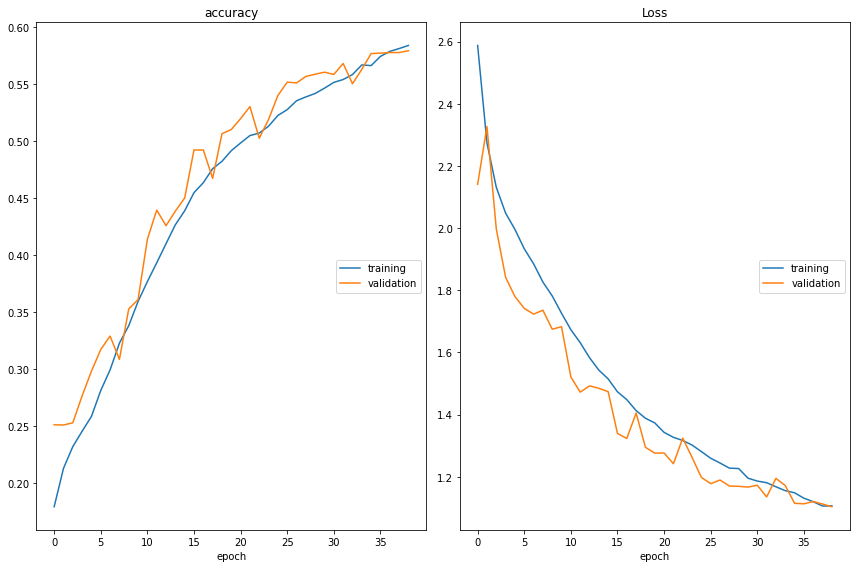

accuracy
	training         	 (min:    0.180, max:    0.584, cur:    0.584)
	validation       	 (min:    0.251, max:    0.579, cur:    0.579)
Loss
	training         	 (min:    1.106, max:    2.588, cur:    1.106)
	validation       	 (min:    1.103, max:    2.327, cur:    1.103)
179/179 [==============================] - 600s 3s/step - loss: 1.1062 - accuracy: 0.5840 - val_loss: 1.1034 - val_accuracy: 0.5794
Epoch 40/40
 14/179 [=>............................] - ETA: 4:50 - loss: 1.1020 - accuracy: 0.5837

KeyboardInterrupt: 

In [21]:
# Train model
epochs = 40
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001, mode='auto')

# Stop training when val loss has stopped improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# Save model weights
checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=2)

# Train model
history = ref_model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, PlotLossesKeras()],
)

accuracy
	training         	 (min:    0.180, max:    0.581, cur:    0.581)
	validation       	 (min:    0.251, max:    0.578, cur:    0.578)
Loss
	training         	 (min:    1.106, max:    2.588, cur:    1.106)
	validation       	 (min:    1.112, max:    2.327, cur:    1.112)

<h3>Testing with test set and graphs</h3>

In [10]:
# Evaluate Model
ref_model.load_weights('model_weights.h5')
ref_model.evaluate(test_generator)
y_pred = ref_model.predict(test_generator, test_generator.n//test_generator.batch_size+1)

57/57 [==============================] - 67s 793ms/step - loss: 1.0947 - accuracy: 0.5900


[1.0947343111038208, 0.5899972319602966]

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
(7178,)
(7178, 7)


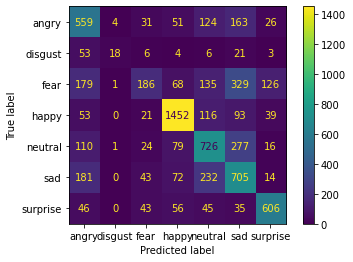

In [14]:
# Confusion Matrix
classes = list(test_generator.class_indices.keys())
print(classes)
y_true = test_generator.classes
print(y_true.shape)
print(y_pred.shape)
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()


In [15]:
# Calculate metrics
print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=classes))

# Calculate Precision, Recall, F1 score
precision, recall, fscore, support = precision_recall_fscore_support(y_true, np.argmax(y_pred, axis=1), average='macro')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", fscore)


              precision    recall  f1-score   support

       angry       0.47      0.58      0.52       958
     disgust       0.75      0.16      0.27       111
        fear       0.53      0.18      0.27      1024
       happy       0.81      0.82      0.82      1774
     neutral       0.52      0.59      0.55      1233
         sad       0.43      0.57      0.49      1247
    surprise       0.73      0.73      0.73       831

    accuracy                           0.59      7178
   macro avg       0.61      0.52      0.52      7178
weighted avg       0.60      0.59      0.58      7178

Precision: 0.6075191377548995
Recall: 0.5184579861988718
F1 Score: 0.5216784405663042


<h2>New Model with hyper parameters optimised</h2>